In [1]:
import sailboat as sb # local file sailboat.py
# this is to be able to edit the sailboat.py file and no need to refresh
%load_ext autoreload 
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
import pytz
import pandas as pd
eastern = pytz.timezone('US/Eastern')
from matplotlib.dates import DayLocator, DateFormatter

In [2]:
url, dates = sb.gen_url(telemetry='all', BB3='all', limit=2000)
df = sb.get_data(url, dates)
df.loc[df['CDOM [QSU]']<0, ['PressureInches', 'AirTemp',
       'WindAppSpeed', 'WindDegOffBow', 'WindTrueSpeed', 'WindTrueDir',
       'CDOM [QSU]', 'Chl. a [ppb]', 'Phycocyanin [ppb]']] = np.nan
df.set_index('GPSTimeStamp', inplace=True)
df.rename(columns={'WindTrueSpeed': 'Wind speed [knts]'}, inplace=True)
df['Air Temp [ºF]']= df['AirTemp'] * 9/5 + 32
df.loc[df['CDOM [QSU]'].isnull(), ['Air Temp [ºF]', 'Wind speed [knts]']]= np.nan
df['UWIND'] = df['Wind speed [knts]']*np.sin(df['WindTrueDir']*np.pi/180.)*0.514444
df['VWIND'] = df['Wind speed [knts]']*np.cos(df['WindTrueDir']*np.pi/180.)*0.514444

Data variables are: ['GPSTimeStamp', 'BB3 [Time UTC]']


In [ ]:
names = ['Wind speed [knts]', 'Air Temp [ºF]']
fig, host = plt.subplots(figsize=(10,3))

par1 = host.twinx()

for var, ax, c in zip(names, [host, par1,], ['b', 'r',]): 
    nav[var].plot(label=var, c=c, ax=ax)
    gfs[var].plot(c=c, ls=':', ax=ax)
    ax.tick_params(axis='y', labelcolor=c, labelsize='medium',)
    ax.set_ylabel(var, color=c, size=12)
    
host.axvspan(gfs.time.values[0], gfs.time.values[-1], alpha=0.2, color='grey')
host.set_xlim(datetime.now()-timedelta(weeks=2), datetime.now()+timedelta(weeks=1))
host.set_ylim(0, 50)
par1.set_ylim(40, 100)
host.set_xlabel('')

host.xaxis.set_major_locator(DayLocator(interval=2))
host.xaxis.set_major_formatter(DateFormatter('%b-%d'))
par1.text(datetime.now()+timedelta(days=1), 95, 'Forecast')

In [68]:
gfsW = xr.open_dataset('../gfs/forecast_WIND.nc').sel(latitude=slice(27, 27.25), longitude=slice(360-81, 360-80.75))
gfsW['Wind speed [knts]'] = np.sqrt(gfsW['UGRD_10maboveground']*gfsW['UGRD_10maboveground'] +
                                    gfsW['VGRD_10maboveground'] + gfsW['VGRD_10maboveground'])* 1.943844
gfs = gfsW.mean(dim=['latitude', 'longitude']).compute()
gfs['Air Temp [ºF]']= (gfs['TMP_surface'] - 273.15) * 9/5 + 32
gfs['Rainfall [in]']= gfs['PRATE_surface']* 86400/ 25.4
gfsW

/Users/hboi/miniconda3/envs/owl/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


<xarray.Dataset>
Dimensions:              (latitude: 2, longitude: 2, time: 136)
Coordinates:
  * latitude             (latitude) float64 27.0 27.25
  * longitude            (longitude) float64 279.0 279.2
  * time                 (time) datetime64[ns] 2021-07-01T01:00:00 ... 2021-0...
Data variables:
    GUST_surface         (time, latitude, longitude) float32 5.002 ... 7.109
    UGRD_10maboveground  (time, latitude, longitude) float32 -3.197 ... 3.597
    VGRD_10maboveground  (time, latitude, longitude) float32 -1.033 ... -0.05056
    PRES_surface         (time, latitude, longitude) float32 1.016e+05 ... 1....
    TMP_surface          (time, latitude, longitude) float32 297.7 ... 298.9
    PRATE_surface        (time, latitude, longitude) float32 0.0001884 ... 4....
    Wind speed [knts]    (time, latitude, longitude) float32 5.551 ... 6.965
Attributes:
    Conventions:          COARDS
    History:              created by wgrib2
    GRIB2_grid_template:  0

Text(0.5, 0, '')

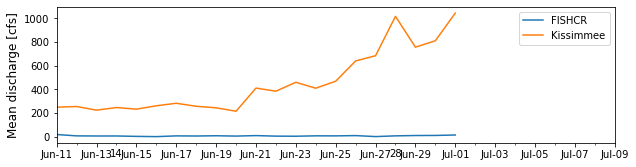

In [52]:
river = pd.read_csv('../dbhydro/dbhydro_river.csv', parse_dates=['Daily Date'], index_col='Daily Date')
river['Kissimmee'] = river['S154_C'] + river['S65E_S'] + river['S84X_S'] + river['S84_S'] + river['S65EX1_S']

fig, ax = plt.subplots(figsize=(10,2.5))
for d in ['FISHCR', 'Kissimmee']:
    river[d].plot(ax=ax).legend(loc='upper right')
ax.set_ylabel('Mean discharge [cfs]', size=12)
ax.set_xlim(datetime.now()-timedelta(weeks=3), datetime.now()+timedelta(weeks=1))
ax.xaxis.set_major_locator(DayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter('%b-%d'))

ax.set_xlabel('')

/Users/hboi/miniconda3/envs/owl/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


Text(0.5, 0, '')

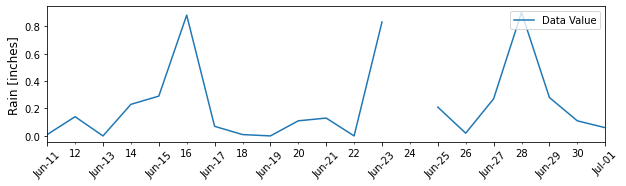

In [66]:
# rain = pd.read_csv('../dbhydro/rainL5.csv', parse_dates=['Daily Date'], index_col='Daily Date')
date_parser = lambda x: datetime.strptime(x, "%m/%d/%y %H:%M")
rain = pd.read_csv('/Users/hboi/Downloads/REPORT-6.csv',
                  parse_dates=['Daily Date'], 
#                    date_parser=date_parser,
                   index_col='Daily Date')
fig, ax = plt.subplots(figsize=(10,2.5))

rain['Data Value'].plot(ax=ax).legend(loc='upper right')
ax.set_ylabel('Rain [inches]', size=12)
# ax.set_xlim(datetime.now()-timedelta(weeks=2), datetime.now()+timedelta(weeks=1))
ax.set_xticklabels(ax.get_xticks(), rotation = 45)
ax.xaxis.set_major_locator(DayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter('%b-%d'))

ax.set_xlabel('')

Text(0.5, 0, '')

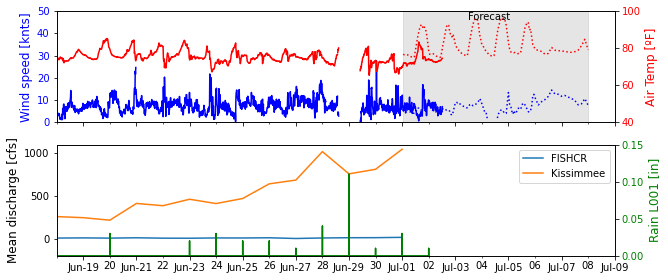

In [60]:
names = ['Wind speed [knts]', 'Air Temp [ºF]']
fig, host = plt.subplots(2, 1, figsize=(10,5), sharex=True)

par1 = host[0].twinx()

for var, ax, c in zip(names, [host[0], par1,], ['b', 'r',]): 
    df[var].plot(label=var, c=c, ax=ax)
    gfs[var].plot(c=c, ls=':', ax=ax)
    ax.tick_params(axis='y', labelcolor=c, labelsize='medium',)
    ax.set_ylabel(var, color=c, size=12)
    
host[0].axvspan(gfs.time.values[0], gfs.time.values[-1], alpha=0.2, color='grey')
host[0].set_xlim(datetime.now()-timedelta(weeks=2), datetime.now()+timedelta(weeks=1))
host[0].set_ylim(0, 50)
par1.set_ylim(40, 100)
host[0].set_xlabel('')
host[0].xaxis.set_major_locator(DayLocator(interval=2))
host[0].xaxis.set_major_formatter(DateFormatter('%b-%d'))

par1.text(datetime.now()+timedelta(days=1), 95, 'Forecast')

for d in ['FISHCR', 'Kissimmee']:
    river[d].plot(ax=host[1]).legend(loc='upper right')
host[1].set_ylabel('Mean discharge [cfs]', size=12)
host[1].set_ylim(-200, 1100)


par2 = host[1].twinx()
par2.tick_params(axis='y', labelcolor='g', labelsize='medium',)
par2.set_ylabel('Rain L001 [in]', color='g', size=12)
par2.set_ylim(0, .15)
rain.plot(ax=par2, c='g', legend=False)

host[1].set_xlim(datetime.now()-timedelta(weeks=2), datetime.now()+timedelta(weeks=1))

# ax.set_xticklabels(ax.get_xticks(), rotation = 45)
host[1].xaxis.set_major_locator(DayLocator(interval=2))
host[1].xaxis.set_major_formatter(DateFormatter('%b-%d'))
host[1].set_xlabel('')


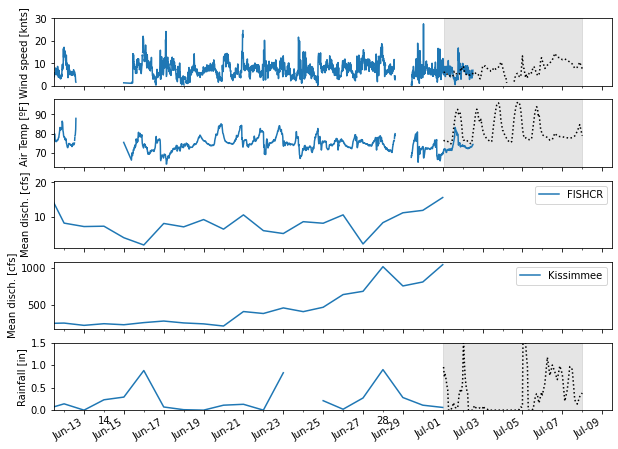

In [71]:
fig, axes = plt.subplots(5, 1, figsize=(10,8), sharex=True)

df['Wind speed [knts]'].plot(ax=axes[0])
gfs['Wind speed [knts]'].plot(ls=':', c='k', ax=axes[0])
axes[0].axvspan(gfs.time.values[0], gfs.time.values[-1], alpha=0.2, color='grey')
axes[0].set_ylabel('Wind speed [knts]')
axes[0].set_ylim(0,30)
df['Air Temp [ºF]'].plot(ax=axes[1])
gfs['Air Temp [ºF]'].plot(ls=':', c='k', ax=axes[1])
axes[1].axvspan(gfs.time.values[0], gfs.time.values[-1], alpha=0.2, color='grey')
axes[1].set_ylabel('Air Temp [ºF]')
river['FISHCR'].plot(ax=axes[2], label='FISHCR').legend()
axes[2].set_ylabel('Mean disch. [cfs]')
river['Kissimmee'].plot(ax=axes[3], label='Kissimmee').legend()
axes[3].set_ylabel('Mean disch. [cfs]')
rain['Data Value'].plot(ax=axes[4])
axes[4].axvspan(gfs.time.values[0], gfs.time.values[-1], alpha=0.2, color='grey')
axes[4].set_ylabel('Rainfal [in/day]')
axes[4].set_ylim(0,1.5)
gfs['Rainfall [in]'].plot(ls=':', c='k', ax=axes[4])
    
axes[-1].set_xlim(datetime.now()-timedelta(weeks=3), datetime.now()+timedelta(weeks=1))
axes[-1].xaxis.set_major_locator(DayLocator(interval=2))
axes[-1].xaxis.set_major_formatter(DateFormatter('%b-%d'))
# axes[-1].tick_params(axis='x', which='minor', bottom=False)
axes[-1].set_xlabel("")
fig.savefig('/Users/hboi/Desktop/atmo2.png')

In [24]:
# df['AWA']=df['WindDegOffBow'].apply(lambda x: x if x < 180. else x - 360)
# df['AWD'] = df['Heading'] + df['AWA']

# fig, ax = plt.subplots(figsize=(10, 4))
# df['AWA'][:100].plot(ax=ax)
# df['WindDegOffBow'][:100].plot(ax=ax, alpha=.4)
# df['AWD'][:100].plot(ax=ax)
# df['Heading'][:100].plot(ax=ax)
# plt.legend()
# ax.set_ylim(-180, 360)


In [25]:
# df['AWD'] = df['Heading'] - AWA
# # nav = df[['WindTrueSpeed', 'WindTrueDir', 'AirTemp']]
# df.rename(columns={'WindTrueSpeed': 'Wind speed [knts]'}, inplace=True)
# df['Air Temp [ºF]']= nav['AirTemp'] * 9/5 + 32
# df['U']= df['Speed'] * np.sin(df['Track']*np.pi/180.) - df['WindAppSpeed'] * np.sin(AWD*np.pi/180.)
# df['V']= df['Speed'] * np.cos(df['Track']*np.pi/180.) - df['WindAppSpeed'] * np.cos(AWD*np.pi/180.)

In [24]:
# AWA = WindDegOffBow

# H = Heading

# AWS = WindAppSpeed

# COG = Track

# SOG = Speed

#       AWA = + for Starboard,  - for Port 
#       AWD = H + AWA ( 0 < AWD < 360 )

#       u = SOG * Sin (COG) - AWS * Sin (AWD)
#       v = SOG * Cos (COG) - AWS * Cos (AWD)

#       TWS = SQRT ( u*u  + v*v )

#       TWD = ATAN ( u / v ) 

In [ ]:
def plot_ts(wdf, names=['U', 'V'], step=25, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 3), sharex=True)
    Q = ax.quiver(wdf.index[::step].values, np.zeros(wdf[::step].shape[0]),
                  wdf[names[0]][::step].values, wdf[names[1]][::step].values, 
               units='y',
               scale_units='y',
               scale = 1,
#                headlength=1,
#                headaxislength=1,
#                width=0.1,
               alpha=0.4
                 )
    ax.set_xlim(wdf.index.values[0], wdf.index.values[-1])
    ax.set_ylim(-30,30)
    ax.set_yticks([])
#     ax.set_ylabel('Wind quiver')
    qk = ax.quiverkey(Q, 0.15, 0.85, 10, '10 [m/s]', labelpos='E',
                   coordinates='figure')
plot_ts(nav, step=1)

In [ ]:
plot_ts(gfsgrd, names=['UGRD_10maboveground', 'VGRD_10maboveground'], step=1)

In [ ]:
awd.plot()

In [ ]:
import pandas as pd

In [ ]:
df['WindDegOffBow'].plot()

In [ ]:
df['Heading'].plot()

In [ ]:
df['Heading'].plot()

In [ ]:
AWA.plot()

In [ ]:
AWD.plot()

In [ ]:
AWA = 180 - df['WindDegOffBow']
AWD = df['Heading'] - AWA
fig, axes = plt.subplots(2,1, figsize=(10,5))
axes[0].plot(AWA)
axes[1].plot(df['Heading'] - AWA)
axes[1].plot(df['Heading'] + AWA)

In [73]:
np.sin(.5*np.pi)

1.0

In [ ]:
AWD = df['Heading'] - AWA
df['u']= df['Speed'] * np.sin(df['Track']*np.pi/180.) - df['WindAppSpeed'] * np.sin(AWD*np.pi/180.)
df['v']= df['Speed'] * np.cos(df['Track']*np.pi/180.) - df['WindAppSpeed'] * np.cos(AWD*np.pi/180.)
df['ws'] = np.sqrt(u*u + v*v)
df['wd'] = np.arctan(u/v)*180/np.pi+180

fig, axes = plt.subplots(2,1, figsize=(10,5))
df.plot(x='GPSTimeStamp', y='ws', ax=axes[0])
df.plot(x='GPSTimeStamp', y='WindTrueSpeed', ax=axes[0], alpha=.5)
df.plot(x='GPSTimeStamp', y='wd', ax=axes[1])
df.plot(x='GPSTimeStamp', y='WindTrueDir', ax=axes[1], alpha=.5)

fig, ax = plt.subplots(figsize=(10,5))


In [87]:
def plot_ts(wdf, step=25):
    fig, ax = plt.subplots(figsize=(10, 3), sharex=True)
    Q = ax.quiver(wdf['local time'][::step].values, np.zeros(wdf[::step].shape[0]),
                wdf.UWIND[::step].values, wdf.VWIND[::step].values, )#units='width')
    ax.set_xlim(wdf['local time'].values[0], wdf['local time'].values[-1])
    ax.set_yticks([])
    ax.set_ylabel('Wind quiver')
    qk = ax.quiverkey(Q, 0.15, 0.85, 10, '10 m/s', labelpos='E',
                   coordinates='figure')

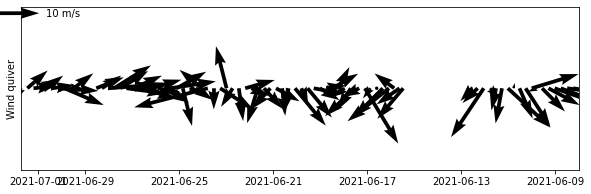

In [88]:
plot_ts(df)

In [ ]:
sb.scatter(df, 'cdom', 'chla', z_var='phyco')

In [ ]:
sb.plot_path(df, 'cdom')